## Capstone Project for Sun Jae Lim
---
**Welcome!**
This notebook is my Capstone Project for The Applied Data Science course on Coursera.

The focus will be: **Determining an Ideal Asian Restaurant Location in Chicago, Illinois**

### 1. Introduction / Business Problem
-------

Restaurants are popular establishments which serve multiple functions. They act as meeting spots, landmarks, introductions to new cultures and cuisines, and provide nourishment. In addition, the industry itself has an upward trend in growth and continues to flourish. 
The National Restaurant Association indicates a projected restaurant industry revenue of nearly 899 billion for 2020, which is a 36 billion increase compared to the industry revenue from 2019 (National Restaurant Association). 

With growth projections seemingly positive for the future, the health of the industry seems robust. Two of the most important factors for establishing a restaurant are location and population.

Our focus will be on setting up a **Korean** restaurant in the city of Chicago, Illinois. Chicago is the third largest city in the United States with over 7,000 restaurants as of 2010 (Chicago.gov). The city represents a ripe opportunity for new restauranteurs or franchise owners to leave their mark and expand their business into a densely populated area.

The project will examine neighborhood populations and nearby venues for each neighborhood and determine which spot would be ideal for setting up an Asian restaurant.


### 2. Data
-------
#### 2.1 Community Areas and Demographics

A list of neighborhoods and associated community areas will be obtained from the Wikipedia page titled ‘List of neighborhoods in Chicago’. The website indicates Chicago neighborhoods have historically changed over time, so the neighborhoods will be grouped into their respective community areas. Defined community areas are not used by residents and may contain several neighborhoods, but their boundaries do not change which allows for comparisons over time (Community areas). 

For community area population data, a CSV table from July 2020 posted on the CMAP Data Hub site maintained by the Illinois government will be imported into our notebook. The data contains various fields, but we will be focusing on fields pertaining to community area age groups and total population from the 2014 to 2018 community survey. All other fields will be dropped.

#### 2.2 Location Data
Foursquare API will be utilized in order to obtain relevant data on venues near the community areas. 


**Summary**

* Neighborhood data will be acquired using pandas from the following Wikipedia page: [Chicago Neighborhoods](https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago). 
* Population data for the community areas will be obtained from the Illinois [CMAP Data Hub](https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e/download/ReferenceCCAProfiles20142018.csv)
* **[Geopy](https://geopy.readthedocs.io/en/stable/#)** will be used to extract coordinates for each neighborhood.
* **[Foursquare API](https://developer.foursquare.com/places)** will be used to collect latitude and longitude values for venues near each of our neighborhoods for mapping. 
* Bar charts will be used to compare neighborhood statistics against eachother, due to neighborhoods being categorical.
* K-means clustering will be used to investigate patterns in similar neighborhoods. The resulting data will be mapped using matplotlib.
* Libraries used, and previously mentioned, will be sourced from pandas, numpy, scikitlearn, matplotlib, and geopy.
* Tables will be presented for any miscellaneous data which is not visualized.

#### Importing the required libraries

In [14]:
#import libraries we will be using
import pandas as pd
import numpy as np

#import requests for Foursquare
import requests

#import our visualization tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans #We will use this for clustering

!pip install folium
import folium

#import geopy to obtain coordinates
!pip install geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent = "coursera_agent_slim")

#We will be using Foursquare, so we will define our credentials
CLIENT_ID = 'TCER0LFUIQJDBLBIHUBKWL3YEAEXZECJPUQEUQ5TLCOVYTEU'
CLIENT_SECRET = 'E3Z4PYK3SGTYNEWJBMFZBDGCEKXKPRMUYZNRLFLHTARHEWHH'
VERSION = '20180605'

#### Extracting Community Area and Neighborhood Data from Wikipedia

In [15]:
#create a URL reference for the Chicago neighborhood wiki page and scrape the data
chicago_wiki = 'https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago'
chicago_convert = pd.read_html(chicago_wiki)
chicago_df_setup = chicago_convert[0]

#Create a dataframe from the wikipedia data
df_chicago = pd.DataFrame(chicago_df_setup[['Neighborhood','Community area']])
df_chicago.rename(columns={"Community area":"CommunityArea"}, inplace=True)

#rename certain community areas
# Austin, Humboldt Park to Austin; Avondale, Irving Park to Avondale; Chatham, Roseland to Chatham; and Lakeview to Lake View
replacements = df_chicago['CommunityArea']
chicago_replacements = replacements.replace({
'Austin, Humboldt Park':'Austin', 
'Avondale, Irving Park':'Avondale',
'Chatham, Roseland':'Chatham',
'Lakeview':'Lake View',
'West Town, Logan Square':'West Town'})
df_replacements = pd.DataFrame(chicago_replacements)

In [16]:
#replace the original df_chicago['CommunityArea'] column with the new one
df_chicago['CommunityArea'] = df_replacements['CommunityArea']

Normally we would use neighborhood data for analysis; however Chicago has a history of shifting neighborhood identities.
We will instead focus on the 77 community areas, which have defined borders and are used for statistical purposes.

In [17]:
#Change our data frame to encompass unique community areas and group neighborhoods
df_chicago_ca = df_chicago['Neighborhood'].groupby(df_chicago['CommunityArea']).unique()
df_chicago_grouped = pd.DataFrame(df_chicago_ca).reset_index()
df_chicago_grouped

,CommunityArea,Neighborhood
0,Albany Park,"[Albany Park, Mayfair, North Mayfair, Ravenswo..."
1,Archer Heights,[Archer Heights]
2,Armour Square,"[Armour Square, Chinatown, Wentworth Gardens]"
3,Ashburn,"[Ashburn, Ashburn Estates, Beverly View, Crest..."
4,Auburn Gresham,"[Auburn Gresham, Gresham]"
5,Austin,"[Galewood, The Island, North Austin, South Aus..."
6,Avalon Park,"[Avalon Park, Marynook, Stony Island Park]"
7,Avondale,"[Avondale, Jackowo, Polish Village, Wacławowo]"
8,Belmont Cragin,"[Belmont Central, Brickyard, Cragin, Hanson Park]"
9,Beverly,"[Beverly, East Beverly, West Beverly]"


In [18]:
#Remove the brackets from out Neighborhoods
df_chicago_grouped['Neighborhood'] = df_chicago_grouped['Neighborhood'].astype('str') 
df_chicago_grouped['Neighborhood'] = df_chicago_grouped['Neighborhood'].str.strip('[]')
df_chicago_grouped.head()

,CommunityArea,Neighborhood
0,Albany Park,'Albany Park' 'Mayfair' 'North Mayfair' 'Raven...
1,Archer Heights,'Archer Heights'
2,Armour Square,'Armour Square' 'Chinatown' 'Wentworth Gardens'
3,Ashburn,'Ashburn' 'Ashburn Estates' 'Beverly View' 'Cr...
4,Auburn Gresham,'Auburn Gresham' 'Gresham'


Additional data we will use to compare community areas will be population values from the 2000 to 2010 census, as well as from a 2014 to 2018 population survey. Given that the data is outdated, we will assume the population and age data are roughly the same as the figures from the 2014 to 2018 survey. 

The population data will be used as a rough guideline for comparing which community areas have historically been home to more people over the past two decades.

In [19]:
#Extract data from the Chicago Community Area csv table from the Illinois government website
chicago_community_data = 'https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e/download/ReferenceCCAProfiles20142018.csv'
df_community_data_raw = pd.read_csv(chicago_community_data)

In [20]:
#Find out what the column names are
print(df_community_data_raw.columns)

Index(['GEOG', '2000_POP', '2010_POP', 'TOT_POP', 'UND19', 'A20_34', 'A35_49',
       'A50_64', 'A65_74', 'A75_84',
       ...
       '2000_ASSOC', '2000_BACH', '2000_GRAD_PROF', '2000_POP_25OV',
       'HT_Cost_Typical', 'HT_Cost_Mod', 'H_Cost_Typical', 'H_Cost_Mod',
       'T_Cost_Typical', 'T_Cost_Mod'],
      dtype='object', length=221)


In [21]:
#We will be using the most recent population data, age ranges, and racial groups
df_community_data_extracted = df_community_data_raw[['GEOG','TOT_POP','UND19','A20_34','A35_49','A50_64','A65_74', 'A75_84','OV85','MED_AGE']]
df_community_data_extracted.head()

,GEOG,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,OV85,MED_AGE
0,Albany Park,50342.99998,12924.999990,12891.999990,11619.999990,8083.999996,2716.999999,1491.999999,613.000000,34.300953
1,Archer Heights,13055.08151,4180.292247,2753.618290,2815.956263,1672.978132,985.051690,400.184891,247.000000,32.654702
2,Armour Square,13779.11840,2542.408010,2788.930936,2297.106212,2520.154383,1922.259432,1163.746373,544.513059,45.738479
3,Ashburn,43985.99999,12981.000000,8464.999998,9192.999998,8529.999996,3057.000000,1147.000000,613.000000,35.901153
4,Auburn Gresham,45271.00001,11183.000000,8665.000001,7891.000000,9595.000003,3860.000001,3204.000000,873.000000,40.780428


In [22]:
#round our values and rename
df_community_data_extracted = df_community_data_extracted.round(0) #round the values to get rid of long floating numbers
df_community_data = df_community_data_extracted.rename(columns={"GEOG":"CommunityArea","TOT_POP":"Population"})
df_community_data.head(10)

,CommunityArea,Population,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,OV85,MED_AGE
0,Albany Park,50343.0,12925.0,12892.0,11620.0,8084.0,2717.0,1492.0,613.0,34.0
1,Archer Heights,13055.0,4180.0,2754.0,2816.0,1673.0,985.0,400.0,247.0,33.0
2,Armour Square,13779.0,2542.0,2789.0,2297.0,2520.0,1922.0,1164.0,545.0,46.0
3,Ashburn,43986.0,12981.0,8465.0,9193.0,8530.0,3057.0,1147.0,613.0,36.0
4,Auburn Gresham,45271.0,11183.0,8665.0,7891.0,9595.0,3860.0,3204.0,873.0,41.0
5,Austin,94762.0,25491.0,21226.0,17324.0,17887.0,7822.0,3920.0,1092.0,36.0
6,Avalon Park,9738.0,2218.0,1547.0,1593.0,2229.0,958.0,890.0,304.0,45.0
7,Avondale,37909.0,8749.0,12371.0,8156.0,4963.0,2283.0,979.0,408.0,33.0
8,Belmont Cragin,80648.0,24495.0,17002.0,18381.0,13769.0,4477.0,1913.0,611.0,34.0
9,Beverly,20437.0,5158.0,2830.0,4144.0,4992.0,2102.0,862.0,349.0,43.0


We will use Geopy to obtain the coordinates for our community areas

In [23]:
#create empty lists for latitude and longitude data
columns_df = ['CommunityArea','Latitude','Longitude']
df_coordinates = pd.DataFrame(columns = columns_df)
df_coordinates['CommunityArea']=df_chicago_grouped['CommunityArea']
locations = df_coordinates['CommunityArea'].values
latitude_ca = []
longitude_ca = []

In [24]:
#View our community areas
locations

array(['Albany Park', 'Archer Heights', 'Armour Square', 'Ashburn',
       'Auburn Gresham', 'Austin', 'Avalon Park', 'Avondale',
       'Belmont Cragin', 'Beverly', 'Bridgeport', 'Brighton Park',
       'Burnside', 'Calumet Heights', 'Chatham', 'Chicago Lawn',
       'Clearing', 'Douglas', 'Dunning', 'East Garfield Park',
       'East Side', 'Edgewater', 'Edison Park', 'Englewood',
       'Forest Glen', 'Fuller Park', 'Gage Park', 'Garfield Ridge',
       'Grand Boulevard', 'Greater Grand Crossing', 'Hegewisch',
       'Hermosa', 'Humboldt Park', 'Hyde Park', 'Irving Park',
       'Jefferson Park', 'Kenwood', 'Lake View', 'Lincoln Park',
       'Lincoln Square', 'Logan Square', 'Lower West Side',
       'McKinley Park', 'Montclare', 'Morgan Park', 'Mount Greenwood',
       'Near North Side', 'Near South Side', 'Near West Side', 'New City',
       'North Center', 'North Lawndale', 'North Park', 'Norwood Park',
       "O'Hare", 'Oakland', 'Portage Park', 'Pullman', 'Riverdale',
       '

In [25]:
#create a loop to obtain all coordinate values for our 77 community areas
for z in locations:
    try:
        query_ll = "{}, Chicago, Illinois"
        location = geolocator.geocode(query_ll.format(z))
        latitude_ca.append(location.latitude)
        longitude_ca.append(location.longitude)
        query_result = "{}, latitude {}, longitude {}"
        print(query_result.format(z, location.latitude, location.longitude))
    except AttributeError:
        latitude_ca.append(0)
        longitude_ca.append(0)
        query_fail = "{} has no location."
        print(query_fail.format(z))

Albany Park, latitude 41.9719367, longitude -87.7161739
Archer Heights, latitude 41.8114215, longitude -87.7261651
Armour Square, latitude 41.8400333, longitude -87.633107
Ashburn, latitude 41.7475332, longitude -87.7111628
Auburn Gresham, latitude 41.74338725, longitude -87.6560415931265
Austin, latitude 41.8878759, longitude -87.7648508
Avalon Park, latitude 41.7450346, longitude -87.5886584
Avondale, latitude 41.9389208, longitude -87.711168
Belmont Cragin, latitude 41.9316983, longitude -87.7686699
Beverly, latitude 41.7181532, longitude -87.6717674
Bridgeport, latitude 41.8379385, longitude -87.651028
Brighton Park, latitude 41.8189217, longitude -87.6989421
Burnside, latitude 41.7300345, longitude -87.596714
Calumet Heights, latitude 41.7300347, longitude -87.5792134
Chatham, latitude 41.7411454, longitude -87.6125481
Chicago Lawn, latitude 41.7750332, longitude -87.6964408
Clearing, latitude 41.780588, longitude -87.7733881
Douglas, latitude 41.8348565, longitude -87.6179536
Dun

In [26]:
#Add the coordinates to our df_coordinates dataframe
df_coordinates['Latitude']=latitude_ca
df_coordinates['Longitude']=longitude_ca

In [27]:
#view the dataframe
df_coordinates

,CommunityArea,Latitude,Longitude
0,Albany Park,41.971937,-87.716174
1,Archer Heights,41.811422,-87.726165
2,Armour Square,41.840033,-87.633107
3,Ashburn,41.747533,-87.711163
4,Auburn Gresham,41.743387,-87.656042
5,Austin,41.887876,-87.764851
6,Avalon Park,41.745035,-87.588658
7,Avondale,41.938921,-87.711168
8,Belmont Cragin,41.931698,-87.768670
9,Beverly,41.718153,-87.671767


### 3. Modeling and Analyzing the Data
Placeholder

In [28]:
#We will examine the top 10 community areas according to the following: age groups, median age (youngest to oldest), and overall population
df_population = df_community_data.sort_values(by=['Population'], ascending=False)
df_population_top10 = df_population[:10]
df_population_top10

,CommunityArea,Population,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,OV85,MED_AGE
37,Lake View,100547.0,12125.0,49269.0,20067.0,11077.0,4798.0,2342.0,869.0,31.0
5,Austin,94762.0,25491.0,21226.0,17324.0,17887.0,7822.0,3920.0,1092.0,36.0
46,Near North Side,89995.0,7989.0,37224.0,15675.0,14851.0,8927.0,4136.0,1193.0,35.0
75,West Town,84255.0,13212.0,38188.0,19224.0,8688.0,2995.0,1480.0,468.0,32.0
8,Belmont Cragin,80648.0,24495.0,17002.0,18381.0,13769.0,4477.0,1913.0,611.0,34.0
74,West Ridge,77212.0,21420.0,16735.0,14840.0,14012.0,5913.0,2929.0,1363.0,35.0
63,South Lawndale,74943.0,23798.0,20142.0,15112.0,10241.0,3412.0,1740.0,498.0,30.0
40,Logan Square,72724.0,14180.0,28051.0,16508.0,8825.0,3146.0,1548.0,466.0,32.0
38,Lincoln Park,68697.0,11928.0,30454.0,12008.0,8222.0,3855.0,1712.0,518.0,30.0
56,Portage Park,64954.0,15354.0,13894.0,14046.0,13644.0,4325.0,2504.0,1188.0,38.0


<function matplotlib.pyplot.show(*args, **kw)>

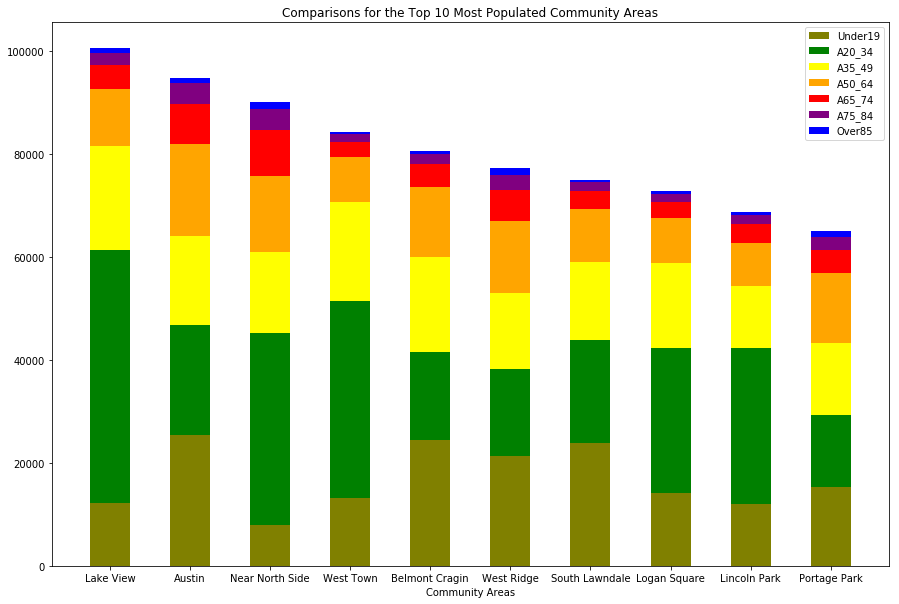

In [29]:
#Let's examine what the top ten most populated community areas look like
Under19 = df_population_top10['UND19'].values.tolist()
Age20_34 = df_population_top10['A20_34'].values.tolist()
Age35_49 = df_population_top10['A35_49'].values.tolist()
Age50_64 = df_population_top10['A50_64'].values.tolist()
Age65_74 = df_population_top10['A65_74'].values.tolist()
Age75_84 = df_population_top10['A75_84'].values.tolist()
Over85 = df_population_top10['OV85'].values.tolist()
Communities = df_population_top10['CommunityArea'].values.tolist()

N= 10
position = np.arange(N)
barnames = Communities
barwidth = 0.5

#create stacked heights for our bars
stack1 = np.add(Under19, Age20_34).tolist()
stack2 = np.add(stack1, Age35_49).tolist()
stack3 = np.add(stack2, Age50_64).tolist()
stack4 = np.add(stack3, Age65_74).tolist()
stack5 = np.add(stack4, Age75_84).tolist()

#Set figure size
fig =  plt.figure(figsize=(15, 10))

#create our bars
plt.bar(position, Under19, color='Olive', width=barwidth, label = "Under19")
plt.bar(position, Age20_34, bottom=Under19, color='Green', width=barwidth, label = "A20_34")
plt.bar(position, Age35_49, bottom=stack1, color='Yellow', width=barwidth, label = "A35_49")
plt.bar(position, Age50_64, bottom=stack2, color='Orange', width=barwidth, label = "A50_64")
plt.bar(position, Age65_74, bottom=stack3, color='Red', width=barwidth, label = "A65_74")
plt.bar(position, Age75_84, bottom=stack4, color='Purple', width=barwidth, label = "A75_84")
plt.bar(position, Over85, bottom=stack5, color='Blue', width=barwidth, label = "Over85")

#Axis labeling
plt.xticks(position, barnames)
plt.xlabel('Community Areas')
plt.title('Comparisons for the Top 10 Most Populated Community Areas')
plt.legend(loc = "upper right")
plt.show

In [30]:
#Let's see which community areas have the top 10 largest populations for ages 49 or younger. 
#Create a loop to add all the column values per community area
UND19_Count = df_community_data['UND19'].values.tolist()
Age20_34_Count = df_community_data['A20_34'].values.tolist()
Age35_49_Count = df_community_data['A35_49'].values.tolist()
AgeBelow50_List = []

for x, y, z in zip(UND19_Count, Age20_34_Count, Age35_49_Count):
    entry = x + y + z
    AgeBelow50_List.append(entry)

AgeBelow50_List

[37437.0,
 9750.0,
 7628.0,
 30639.0,
 27739.0,
 64041.0,
 5358.0,
 29276.0,
 59878.0,
 12132.0,
 22641.0,
 34424.0,
 1244.0,
 6792.0,
 18175.0,
 38180.0,
 17775.0,
 14995.0,
 27527.0,
 14766.0,
 17437.0,
 37740.0,
 7720.0,
 15678.0,
 11665.0,
 1181.0,
 31147.0,
 23221.0,
 15790.0,
 20428.0,
 5626.0,
 16765.0,
 42692.0,
 19620.0,
 38225.0,
 17540.0,
 11310.0,
 81461.0,
 54390.0,
 31382.0,
 58739.0,
 24712.0,
 11431.0,
 9333.0,
 12722.0,
 12751.0,
 60888.0,
 17385.0,
 51350.0,
 29098.0,
 28270.0,
 25005.0,
 11670.0,
 21909.0,
 5236.0,
 8506.0,
 43294.0,
 4255.0,
 6112.0,
 40609.0,
 25872.0,
 19971.0,
 9697.0,
 59052.0,
 34381.0,
 28760.0,
 40719.0,
 16682.0,
 8638.0,
 14530.0,
 17679.0,
 12177.0,
 24406.0,
 17914.0,
 52995.0,
 70624.0,
 16297.0]

In [31]:
df_below50 = pd.DataFrame(columns=['CommunityArea','Below50_Sum'])
df_community_areas = df_community_data['CommunityArea'].values.tolist()
df_below50['CommunityArea'] = df_community_areas
df_below50['Below50_Sum'] = AgeBelow50_List
df_below50.head()

,CommunityArea,Below50_Sum
0,Albany Park,37437.0
1,Archer Heights,9750.0
2,Armour Square,7628.0
3,Ashburn,30639.0
4,Auburn Gresham,27739.0


In [32]:
#Let's sort by the top 10 community areas
df_below50_sorted = df_below50.sort_values(by=['Below50_Sum'], ascending=False)
df_below50_top10 = df_below50_sorted[:10]
df_below50_top10

,CommunityArea,Below50_Sum
37,Lake View,81461.0
75,West Town,70624.0
5,Austin,64041.0
46,Near North Side,60888.0
8,Belmont Cragin,59878.0
63,South Lawndale,59052.0
40,Logan Square,58739.0
38,Lincoln Park,54390.0
74,West Ridge,52995.0
48,Near West Side,51350.0


Text(0.5, 1.0, 'Top 10 Community Areas with the Youngest Populations')

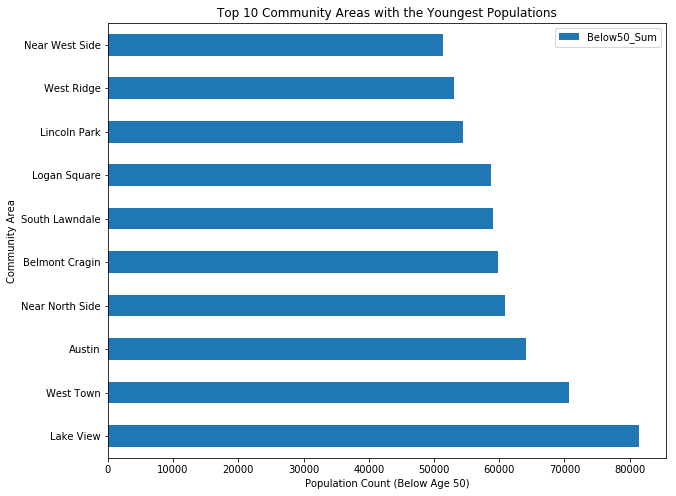

In [33]:
ax = df_below50_top10.plot.barh(x='CommunityArea', y='Below50_Sum', rot=0, figsize=(10,8))
ax.set_xlabel('Population Count (Below Age 50)')
ax.set_ylabel('Community Area')
ax.set_title('Top 10 Community Areas with the Youngest Populations')

It appears the order of our community areas has changed when we focus on the younger population count. Let's plot the top 15 community areas when comparing the total younger population to the total population. We will want to expand the community range and compare.

In [34]:
#Create a dataframe to use for our comparison
df_comparison = pd.DataFrame(columns=['CommunityArea','Population','Below50_Pop'])
df_comparison['CommunityArea']= df_community_data['CommunityArea'].tolist()
df_comparison['Population']= df_community_data['Population']
df_comparison['Below50_Pop']= df_below50['Below50_Sum']
df_comparison.head(5)

,CommunityArea,Population,Below50_Pop
0,Albany Park,50343.0,37437.0
1,Archer Heights,13055.0,9750.0
2,Armour Square,13779.0,7628.0
3,Ashburn,43986.0,30639.0
4,Auburn Gresham,45271.0,27739.0


In [35]:
#Order by greatest population and take the top 15
df_comparison_sorted = df_comparison.sort_values(by=['Population'], ascending = False)
df_comparison_top15 = df_comparison_sorted[:15]
df_comparison_top15

,CommunityArea,Population,Below50_Pop
37,Lake View,100547.0,81461.0
5,Austin,94762.0,64041.0
46,Near North Side,89995.0,60888.0
75,West Town,84255.0,70624.0
8,Belmont Cragin,80648.0,59878.0
74,West Ridge,77212.0,52995.0
63,South Lawndale,74943.0,59052.0
40,Logan Square,72724.0,58739.0
38,Lincoln Park,68697.0,54390.0
56,Portage Park,64954.0,43294.0


In [36]:
#Let's set the index to the community area
df_comparison_plot = df_comparison_top15.set_index('CommunityArea')

Text(0.5, 1.0, "Total vs Below 50 Population in Chicago's Top 15 Most Populated Areas")

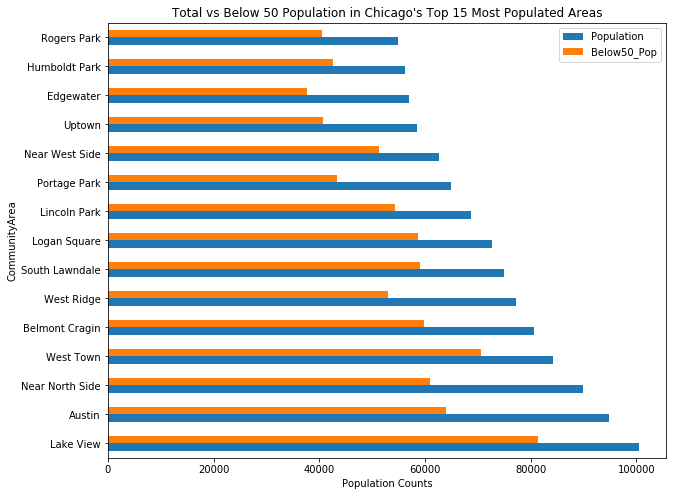

In [37]:
#Let's try graphing the plot
ax2 = df_comparison_plot.plot.barh(rot=0, figsize=(10,8))
ax2.set_xlabel('Population Counts')
ax2.set_title('Total vs Below 50 Population in Chicago\'s Top 15 Most Populated Areas')

Some community areas have a smaller total population, but a larger demographic of younger residents. Let's see which community areas would be the most viable when ordered by population of residents below the age of 50.

In [38]:
#create the new dataframe
df_comparison_sorted_2 = df_comparison.sort_values(by=['Below50_Pop'], ascending = False)
df_comparison_below50_top15 = df_comparison_sorted_2[:15]
df_comparison_below50_top15

,CommunityArea,Population,Below50_Pop
37,Lake View,100547.0,81461.0
75,West Town,84255.0,70624.0
5,Austin,94762.0,64041.0
46,Near North Side,89995.0,60888.0
8,Belmont Cragin,80648.0,59878.0
63,South Lawndale,74943.0,59052.0
40,Logan Square,72724.0,58739.0
38,Lincoln Park,68697.0,54390.0
74,West Ridge,77212.0,52995.0
48,Near West Side,62733.0,51350.0


In [39]:
#set the index to the community areas
df_below50 = df_comparison_below50_top15.set_index('CommunityArea')
df_below50

,Population,Below50_Pop
CommunityArea,,
Lake View,100547.0,81461.0
West Town,84255.0,70624.0
Austin,94762.0,64041.0
Near North Side,89995.0,60888.0
Belmont Cragin,80648.0,59878.0
South Lawndale,74943.0,59052.0
Logan Square,72724.0,58739.0
Lincoln Park,68697.0,54390.0
West Ridge,77212.0,52995.0


Text(0.5, 1.0, "Below 50 Age Group vs Total Population in Chicago's Top 15 Areas with the Youngest Demographic")

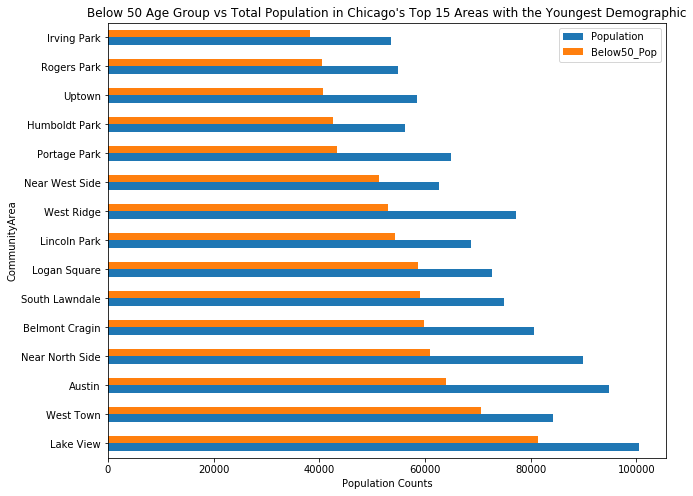

In [40]:
#Let's try graphing the plot
ax3 = df_below50.plot.barh(rot=0, figsize=(10,8))
ax3.set_xlabel('Population Counts')
ax3.set_title('Below 50 Age Group vs Total Population in Chicago\'s Top 15 Areas with the Youngest Demographic')

Despite the difference in total population, some of our top communities appear to have a large demographic of older residents. Next, we will focus on obtaining venues from our neighborhoods.

In [41]:
#We imported our credentials earlier. Let's use the Foursquare API to gather relevant venue data.
LIMIT= 100
radius = 500

#Create a function for obtaining venues
def NearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        #define the Foursquare API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(name, lat, lng, 
                             v['venue']['name'], 
                             v['venue']['location']['lat'], 
                             v['venue']['location']['lng'],
                             v['venue']['categories'][0]['name']) for v in results])
        
    df_nearbyvenues = pd.DataFrame(item for venue_list in venues_list for item in venue_list)
    df_nearbyvenues.columns = ['CommunityArea','CA_Latitude','CA_Longitude','Venue','Venue_Latitude','Venue_Longitude','Venue_Category']
    
    return(df_nearbyvenues)

In [43]:
#Obtain venue data
chicago_venues = NearbyVenues(names = df_coordinates['CommunityArea'], latitudes = df_coordinates['Latitude'], longitudes = df_coordinates['Longitude'], radius = 500)

Albany Park
Archer Heights
Armour Square
Ashburn
Auburn Gresham
Austin
Avalon Park
Avondale
Belmont Cragin
Beverly
Bridgeport
Brighton Park
Burnside
Calumet Heights
Chatham
Chicago Lawn
Clearing
Douglas
Dunning
East Garfield Park
East Side
Edgewater
Edison Park
Englewood
Forest Glen
Fuller Park
Gage Park
Garfield Ridge
Grand Boulevard
Greater Grand Crossing
Hegewisch
Hermosa
Humboldt Park
Hyde Park
Irving Park
Jefferson Park
Kenwood
Lake View
Lincoln Park
Lincoln Square
Logan Square
Lower West Side
McKinley Park
Montclare
Morgan Park
Mount Greenwood
Near North Side
Near South Side
Near West Side
New City
North Center
North Lawndale
North Park
Norwood Park
O'Hare
Oakland
Portage Park
Pullman
Riverdale
Rogers Park
Roseland
South Chicago
South Deering
South Lawndale
South Shore
The Loop
Uptown
Washington Heights
Washington Park
West Elsdon
West Englewood
West Garfield Park
West Lawn
West Pullman
West Ridge
West Town
Woodlawn


In [44]:
#Let's view our data
print("The shape of chicago_venues:", chicago_venues.shape)
chicago_venues.head(15)

The shape of chicago_venues: (1550, 7)


,CommunityArea,CA_Latitude,CA_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Albany Park,41.971937,-87.716174,Chicago Produce,41.970553,-87.716327,Grocery Store
1,Albany Park,41.971937,-87.716174,Cairo Nights Hookah Lounge,41.975776,-87.715547,Hookah Bar
2,Albany Park,41.971937,-87.716174,Nighthawk,41.967974,-87.713415,Cocktail Bar
3,Albany Park,41.971937,-87.716174,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
4,Albany Park,41.971937,-87.716174,Popeyes Louisiana Kitchen,41.968756,-87.713019,Fried Chicken Joint
5,Albany Park,41.971937,-87.716174,Banpojung,41.975707,-87.715609,Korean Restaurant
6,Albany Park,41.971937,-87.716174,Markellos Baking Company,41.968602,-87.716607,Bakery
7,Albany Park,41.971937,-87.716174,Subway,41.968748,-87.712861,Sandwich Place
8,Albany Park,41.971937,-87.716174,T-Mobile,41.968751,-87.713158,Mobile Phone Shop
9,Albany Park,41.971937,-87.716174,Dunkin',41.968255,-87.712964,Donut Shop


In [45]:
#Check the number of unique venues
print("There are {} unique venue types.".format(len(chicago_venues['Venue_Category'].unique())))

#check the number of unique community areas
print("There are {} unique community areas.".format(len(chicago_venues['CommunityArea'].unique())))

There are 247 unique venue types.
There are 75 unique community areas.


In [46]:
#Create a list of values
chicago_venues_values = chicago_venues['CommunityArea'].values.tolist()

In [47]:
#Obtain value counts
chicago_venues_values_series = pd.Series(chicago_venues_values)
chicago_venues_values_series.value_counts()

The Loop              100
Logan Square           73
Lincoln Park           71
Lake View              68
Uptown                 68
North Center           65
Edgewater              58
Near South Side        51
Lincoln Square         47
Lower West Side        45
Bridgeport             39
Rogers Park            37
Douglas                36
West Town              35
Jefferson Park         34
Hyde Park              32
O'Hare                 29
Edison Park            28
Avondale               27
Near North Side        26
Kenwood                22
Near West Side         22
Irving Park            21
McKinley Park          20
West Elsdon            19
Belmont Cragin         18
Portage Park           18
South Lawndale         17
Forest Glen            16
Grand Boulevard        16
                     ... 
Chicago Lawn           12
East Garfield Park     12
Pullman                12
Armour Square          10
Washington Park         9
South Shore             9
Hegewisch               9
Gage Park   

It looks like around 24 community areas have less than 10 venues available. The Loop has the most venues available.

In [49]:
#We appear to be missing some community areas. Let's double check.
community_area_list = df_coordinates['CommunityArea'].values.tolist()
#we defined the following earlier
#chicago_venues_values = chicago_venues['CommunityArea'].values.tolist()

missing_community_areas = [x for x in community_area_list if x not in chicago_venues_values]
print(missing_community_areas)

['Riverdale', 'South Deering']


It appears some community areas did not produce venue results. Let's recheck.

In [50]:
#extract the coordinates for our missing areas
df_missing_areas = df_coordinates.loc[df_coordinates['CommunityArea'].isin(missing_community_areas)]
df_missing_areas

,CommunityArea,Latitude,Longitude
58,Riverdale,41.667835,-87.604964
62,South Deering,41.692236,-87.571703


In [51]:
#Let's double the range of our previous query
chicago_venues_3 = NearbyVenues(names = df_missing_areas['CommunityArea'], latitudes = df_missing_areas['Latitude'], longitudes = df_missing_areas['Longitude'], radius = 1000)
chicago_venues_3

Riverdale
South Deering


,CommunityArea,CA_Latitude,CA_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Riverdale,41.667835,-87.604964,MMA Academy,41.675821,-87.602112,Martial Arts Dojo
1,Riverdale,41.667835,-87.604964,Metra KYD Yard,41.671758,-87.615651,Train Station
2,South Deering,41.692236,-87.571703,Big Marsh,41.687097,-87.571038,Bike Trail
3,South Deering,41.692236,-87.571703,Republic Services Calumet Transfer Station,41.697603,-87.572223,Waste Facility
4,South Deering,41.692236,-87.571703,Park No. 564,41.685486,-87.575012,Park
5,South Deering,41.692236,-87.571703,Harborside Golf Course Hole 12 Bathroom,41.696577,-87.581540,Golf Course


Looks like increasing our radius achieved better results.
We will re-run out previous query using the new radius.

In [52]:
#Use Foursquare API to search all venues again with the doubled radius
chicago_venues_new = NearbyVenues(names = df_coordinates['CommunityArea'], latitudes = df_coordinates['Latitude'], longitudes = df_coordinates['Longitude'], radius = 1000)

#Check the number of unique venues
print("There are {} unique venue types.".format(len(chicago_venues_new['Venue_Category'].unique())))

#check the number of unique community areas
print("There are {} unique community areas.".format(len(chicago_venues_new['CommunityArea'].unique())))

Albany Park
Archer Heights
Armour Square
Ashburn
Auburn Gresham
Austin
Avalon Park
Avondale
Belmont Cragin
Beverly
Bridgeport
Brighton Park
Burnside
Calumet Heights
Chatham
Chicago Lawn
Clearing
Douglas
Dunning
East Garfield Park
East Side
Edgewater
Edison Park
Englewood
Forest Glen
Fuller Park
Gage Park
Garfield Ridge
Grand Boulevard
Greater Grand Crossing
Hegewisch
Hermosa
Humboldt Park
Hyde Park
Irving Park
Jefferson Park
Kenwood
Lake View
Lincoln Park
Lincoln Square
Logan Square
Lower West Side
McKinley Park
Montclare
Morgan Park
Mount Greenwood
Near North Side
Near South Side
Near West Side
New City
North Center
North Lawndale
North Park
Norwood Park
O'Hare
Oakland
Portage Park
Pullman
Riverdale
Rogers Park
Roseland
South Chicago
South Deering
South Lawndale
South Shore
The Loop
Uptown
Washington Heights
Washington Park
West Elsdon
West Englewood
West Garfield Park
West Lawn
West Pullman
West Ridge
West Town
Woodlawn
There are 343 unique venue types.
There are 77 unique community 

In [53]:
#Create a list of values
chicago_venues_values_new = chicago_venues_new['CommunityArea'].values.tolist()

#Obtain value counts
chicago_venues_values_series_new = pd.Series(chicago_venues_values_new)
chicago_venues_values_series_new.value_counts()

Avondale                  100
Near North Side           100
Lake View                 100
North Center              100
Near South Side           100
Lincoln Park              100
Lower West Side           100
Near West Side            100
The Loop                  100
West Town                 100
Uptown                    100
Rogers Park               100
O'Hare                    100
Edgewater                 100
Hyde Park                 100
Lincoln Square             92
Bridgeport                 86
Belmont Cragin             81
Albany Park                78
Logan Square               78
Irving Park                74
West Ridge                 72
Dunning                    69
West Elsdon                64
Humboldt Park              63
Beverly                    63
Portage Park               60
Montclare                  60
McKinley Park              58
Armour Square              57
                         ... 
West Garfield Park         33
Garfield Ridge             33
Chicago La

It appears all community areas are now within our range. 

In [69]:
#one hot encode for venue category
chicago_onehot = pd.get_dummies(chicago_venues_new['Venue_Category'])

In [70]:
#Let's view our onehot columns
chicago_onehot_columns = chicago_onehot.columns.tolist()
chicago_onehot_columns

['ATM',
 'Accessories Store',
 'Afghan Restaurant',
 'African Restaurant',
 'Airport',
 'Airport Lounge',
 'Airport Service',
 'American Restaurant',
 'Amphitheater',
 'Animal Shelter',
 'Antique Shop',
 'Arcade',
 'Argentinian Restaurant',
 'Art Gallery',
 'Art Museum',
 'Arts & Crafts Store',
 'Asian Restaurant',
 'Athletics & Sports',
 'Auditorium',
 'Auto Dealership',
 'Auto Garage',
 'Automotive Shop',
 'BBQ Joint',
 'Bagel Shop',
 'Bakery',
 'Bank',
 'Bar',
 'Baseball Field',
 'Baseball Stadium',
 'Basketball Court',
 'Basketball Stadium',
 'Beach',
 'Bed & Breakfast',
 'Beer Bar',
 'Beer Garden',
 'Beer Store',
 'Big Box Store',
 'Bike Rental / Bike Share',
 'Bike Shop',
 'Bike Trail',
 'Bistro',
 'Boat or Ferry',
 'Bookstore',
 'Botanical Garden',
 'Boutique',
 'Bowling Alley',
 'Brazilian Restaurant',
 'Breakfast Spot',
 'Brewery',
 'Bubble Tea Shop',
 'Buffet',
 'Building',
 'Burger Joint',
 'Burmese Restaurant',
 'Burrito Place',
 'Bus Line',
 'Bus Station',
 'Bus Stop',
 'B

In [71]:
#Let's add the community areas back to the onehot dataframe
chicago_onehot['CommunityArea'] = chicago_venues_new['CommunityArea']

In [72]:
#Let's view our data
print('We have {} community areas'.format(len(chicago_onehot['CommunityArea'].unique())))

We have 77 community areas


In [73]:
#Moving the community areas column to the front
new_columns = chicago_onehot.columns.tolist()
revised_columns = new_columns[-1:] + new_columns[:-1]
chicago_onehot = chicago_onehot[revised_columns]
chicago_onehot.head(15)

,CommunityArea,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Albany Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
#group rows by CommunityArea
chicago_onehot_grouped = chicago_onehot.groupby('CommunityArea').mean().reset_index()
chicago_onehot_grouped

,CommunityArea,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Albany Park,0.000000,0.012821,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
1,Archer Heights,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.028571,0.000000,0.00
2,Armour Square,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.035088,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
3,Ashburn,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.052632,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
4,Auburn Gresham,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.033333,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.033333,0.00,0.000000,0.000000,0.00
5,Austin,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.062500,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
6,Avalon Park,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.033333,0.000000,0.00
7,Avondale,0.010000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
8,Belmont Cragin,0.012346,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.024691,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.00
9,Beverly,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.047619,0.00


In [76]:
#We saw our second lowest venue count was 4 for South Deering and the lowest was 2 for Riverdale
#define a function to obtain the four top venues
number_of_top_venues = 4
def most_common_venues (row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

#create a new dataframe for our ordered data
chicago_top_venues = pd.DataFrame(columns = ['CommunityArea', '1st Venue', '2nd Venue', '3rd Venue', '4th Venue'])

#Add the community area column
chicago_top_venues['CommunityArea'] = chicago_onehot_grouped['CommunityArea']

#add the data
for ind in np.arange(chicago_onehot_grouped.shape[0]):
    chicago_top_venues.iloc[ind, 1:] = most_common_venues(chicago_onehot_grouped.iloc[ind, :], number_of_top_venues)

In [77]:
#Let's view the data
chicago_top_venues.head()

,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,Albany Park,Middle Eastern Restaurant,Grocery Store,Pizza Place,Coffee Shop
1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Fast Food Restaurant
2,Armour Square,Chinese Restaurant,Pizza Place,Bus Station,Bar
3,Ashburn,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint
4,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Lounge


In [78]:
#Let's view the shape
print("The shape is:", chicago_top_venues.shape)

The shape is: (77, 5)


We will cluster our data into groups and proceed to merge it back to the main dataframe

In [79]:
#define k clusters. Let's start with 5.
kclusters = 5
chicago_clusters = chicago_onehot_grouped.drop(['CommunityArea'], 1)
kmeans = KMeans(n_clusters = kclusters, init='k-means++',random_state=0).fit(chicago_clusters)

#check the kmean labels
kmeans.labels_

array([1, 3, 1, 0, 0, 1, 0, 1, 3, 0, 1, 3, 0, 0, 0, 0, 1, 0, 1, 1, 3, 1,
       1, 0, 1, 0, 3, 0, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 1, 1, 1, 3, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 2, 1, 0, 3, 4, 3, 0, 1,
       1, 1, 0, 3, 0, 0, 3, 0, 1, 1, 1], dtype=int32)

In [80]:
chicago_venue_cluster5 = chicago_top_venues.copy(deep = True)

In [81]:
#insert the cluster data into the modified one hot dataframe
chicago_venue_cluster5.insert(0, 'Clusters', kmeans.labels_)
chicago_venue_cluster5.head()

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,1,Albany Park,Middle Eastern Restaurant,Grocery Store,Pizza Place,Coffee Shop
1,3,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Fast Food Restaurant
2,1,Armour Square,Chinese Restaurant,Pizza Place,Bus Station,Bar
3,0,Ashburn,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint
4,0,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Lounge


In [82]:
#Let's group by cluster type and view the data spread
df_cluster_0 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 0]
df_cluster_0

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
3,0,Ashburn,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint
4,0,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Lounge
6,0,Avalon Park,Fast Food Restaurant,Park,Pharmacy,Hot Dog Joint
9,0,Beverly,Fast Food Restaurant,Pizza Place,Mobile Phone Shop,Cosmetics Shop
12,0,Burnside,Fast Food Restaurant,Park,Rental Car Location,Dry Cleaner
13,0,Calumet Heights,Fast Food Restaurant,Pharmacy,Discount Store,Sandwich Place
14,0,Chatham,Sandwich Place,Chinese Restaurant,Kids Store,Fast Food Restaurant
15,0,Chicago Lawn,Park,Cosmetics Shop,Discount Store,Pizza Place
17,0,Douglas,Park,Sandwich Place,Bus Station,Shipping Store
23,0,Englewood,Fast Food Restaurant,Park,Shopping Plaza,Sandwich Place


In [83]:
#Let's view the other clusters
df_cluster_1 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 1]
df_cluster_1

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,1,Albany Park,Middle Eastern Restaurant,Grocery Store,Pizza Place,Coffee Shop
2,1,Armour Square,Chinese Restaurant,Pizza Place,Bus Station,Bar
5,1,Austin,Fried Chicken Joint,Grocery Store,Food Court,Park
7,1,Avondale,Bar,Mexican Restaurant,Donut Shop,Grocery Store
10,1,Bridgeport,Mexican Restaurant,Art Gallery,Chinese Restaurant,Pizza Place
16,1,Clearing,Video Store,Park,American Restaurant,Pizza Place
18,1,Dunning,Cosmetics Shop,Fast Food Restaurant,Shoe Store,Park
19,1,East Garfield Park,Food,Train Station,Liquor Store,Bakery
21,1,Edgewater,Coffee Shop,Mexican Restaurant,Grocery Store,Asian Restaurant
22,1,Edison Park,Bar,Italian Restaurant,Nail Salon,Pizza Place


In [84]:
df_cluster_2 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 2]
df_cluster_2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
58,2,Riverdale,Martial Arts Dojo,Train Station,Yoga Studio,Electronics Store


In [85]:
df_cluster_3 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 3]
df_cluster_3

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
1,3,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Fast Food Restaurant
8,3,Belmont Cragin,Mexican Restaurant,Sandwich Place,Pharmacy,Grocery Store
11,3,Brighton Park,Mexican Restaurant,Taco Place,Sandwich Place,Donut Shop
20,3,East Side,Mexican Restaurant,Community Center,Trail,Convenience Store
26,3,Gage Park,Mexican Restaurant,Grocery Store,Pizza Place,Taco Place
31,3,Hermosa,Mexican Restaurant,Pizza Place,Grocery Store,Liquor Store
41,3,Lower West Side,Mexican Restaurant,Bakery,Pizza Place,Bar
61,3,South Chicago,Mexican Restaurant,Food,Discount Store,Pharmacy
63,3,South Lawndale,Mexican Restaurant,Fast Food Restaurant,Bank,Mobile Phone Shop
69,3,West Elsdon,Mexican Restaurant,Pizza Place,Grocery Store,Fast Food Restaurant


In [86]:
df_cluster_4 = chicago_venue_cluster5.loc[chicago_venue_cluster5['Clusters'] == 4]
df_cluster_4

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
62,4,South Deering,Golf Course,Bike Trail,Park,Waste Facility


Some areas still seem to have large groups with mixed venues. Let's raise the cluster amount and try again.

In [87]:
#define new k clusters. Let's try 10.
kclusters2 = 10
chicago_venue_cluster10 = chicago_top_venues.copy(deep = True)
chicago_clusters10 = chicago_onehot_grouped.drop(['CommunityArea'], 1)
kmeans2 = KMeans(n_clusters = kclusters2, init='k-means++',random_state=0).fit(chicago_clusters10)

#insert the cluster data into the modified one hot dataframe
chicago_venue_cluster10.insert(0, 'Clusters', kmeans2.labels_)
chicago_venue_cluster10.head()

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,4,Albany Park,Middle Eastern Restaurant,Grocery Store,Pizza Place,Coffee Shop
1,1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Fast Food Restaurant
2,4,Armour Square,Chinese Restaurant,Pizza Place,Bus Station,Bar
3,5,Ashburn,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint
4,5,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Lounge


In [88]:
#Let's view our groups
df_cluster_0_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 0]
df_cluster_0_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
26,0,Gage Park,Mexican Restaurant,Grocery Store,Pizza Place,Taco Place


In [89]:
df_cluster_1_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 1]
df_cluster_1_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
1,1,Archer Heights,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Fast Food Restaurant
8,1,Belmont Cragin,Mexican Restaurant,Sandwich Place,Pharmacy,Grocery Store
11,1,Brighton Park,Mexican Restaurant,Taco Place,Sandwich Place,Donut Shop
20,1,East Side,Mexican Restaurant,Community Center,Trail,Convenience Store
27,1,Garfield Ridge,Mexican Restaurant,Park,Discount Store,Hot Dog Joint
31,1,Hermosa,Mexican Restaurant,Pizza Place,Grocery Store,Liquor Store
41,1,Lower West Side,Mexican Restaurant,Bakery,Pizza Place,Bar
43,1,Montclare,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Grocery Store
45,1,Mount Greenwood,Pizza Place,Mexican Restaurant,Fast Food Restaurant,Park
49,1,New City,Discount Store,Pizza Place,Grocery Store,Mexican Restaurant


In [90]:
df_cluster_2_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 2]
df_cluster_2_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
58,2,Riverdale,Martial Arts Dojo,Train Station,Yoga Studio,Electronics Store


In [91]:
df_cluster_3_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 3]
df_cluster_3_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
62,3,South Deering,Golf Course,Bike Trail,Park,Waste Facility


In [92]:
df_cluster_4_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 4]
df_cluster_4_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
0,4,Albany Park,Middle Eastern Restaurant,Grocery Store,Pizza Place,Coffee Shop
2,4,Armour Square,Chinese Restaurant,Pizza Place,Bus Station,Bar
7,4,Avondale,Bar,Mexican Restaurant,Donut Shop,Grocery Store
10,4,Bridgeport,Mexican Restaurant,Art Gallery,Chinese Restaurant,Pizza Place
18,4,Dunning,Cosmetics Shop,Fast Food Restaurant,Shoe Store,Park
21,4,Edgewater,Coffee Shop,Mexican Restaurant,Grocery Store,Asian Restaurant
22,4,Edison Park,Bar,Italian Restaurant,Nail Salon,Pizza Place
24,4,Forest Glen,Filipino Restaurant,Park,Bakery,Music Store
30,4,Hegewisch,Bar,Pizza Place,Market,State / Provincial Park
32,4,Humboldt Park,Bar,Latin American Restaurant,Liquor Store,Deli / Bodega


In [93]:
df_cluster_5_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 5]
df_cluster_5_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
3,5,Ashburn,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint
4,5,Auburn Gresham,Fast Food Restaurant,Pharmacy,Currency Exchange,Lounge
5,5,Austin,Fried Chicken Joint,Grocery Store,Food Court,Park
9,5,Beverly,Fast Food Restaurant,Pizza Place,Mobile Phone Shop,Cosmetics Shop
13,5,Calumet Heights,Fast Food Restaurant,Pharmacy,Discount Store,Sandwich Place
14,5,Chatham,Sandwich Place,Chinese Restaurant,Kids Store,Fast Food Restaurant
15,5,Chicago Lawn,Park,Cosmetics Shop,Discount Store,Pizza Place
16,5,Clearing,Video Store,Park,American Restaurant,Pizza Place
17,5,Douglas,Park,Sandwich Place,Bus Station,Shipping Store
19,5,East Garfield Park,Food,Train Station,Liquor Store,Bakery


In [94]:
df_cluster_6_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 6]
df_cluster_6_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
55,6,Oakland,Beach,BBQ Joint,Coffee Shop,Park


In [95]:
df_cluster_7_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 7]
df_cluster_7_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
6,7,Avalon Park,Fast Food Restaurant,Park,Pharmacy,Hot Dog Joint
12,7,Burnside,Fast Food Restaurant,Park,Rental Car Location,Dry Cleaner
23,7,Englewood,Fast Food Restaurant,Park,Shopping Plaza,Sandwich Place
57,7,Pullman,Park,Train Station,Sandwich Place,Fast Food Restaurant
70,7,West Englewood,Fast Food Restaurant,Liquor Store,Discount Store,Cosmetics Shop


In [96]:
df_cluster_8_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 8]
df_cluster_8_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
44,8,Morgan Park,BBQ Joint,Sandwich Place,Lounge,Intersection


In [97]:
df_cluster_9_test2 = chicago_venue_cluster10.loc[chicago_venue_cluster10['Clusters'] == 9]
df_cluster_9_test2

,Clusters,CommunityArea,1st Venue,2nd Venue,3rd Venue,4th Venue
67,9,Washington Heights,Caribbean Restaurant,American Restaurant,Salon / Barbershop,Basketball Court


It appears North Park or West Ridge are locations with Korean Restaurants nearby.

In [98]:
mylist = ['1st Venue','2nd Venue', '3rd Venue','4th Venue']
newlist = []

for x in mylist:
    venue = chicago_venue_cluster10[chicago_venue_cluster10[x].str.contains("Korean")]
    venue_y = venue['CommunityArea'].values.tolist()
    newlist.extend(venue_y)

modified_list = [x for x in newlist if x !=[]]
print("Community areas with Korean restaurants are: {}".format(modified_list))

Community areas with Korean restaurants are: ['North Park']


In [99]:
#Let's find areas with train stations
trainlist = []

for x in mylist:
    venue = chicago_venue_cluster10[chicago_venue_cluster10[x].str.contains("Train")]
    venue_y = venue['CommunityArea'].values.tolist()
    trainlist.extend(venue_y)

modified_list2 = [x for x in trainlist if x !=[]]
print("Community areas with train stations: {}".format(modified_list2))

Community areas with train stations: ['East Garfield Park', 'Pullman', 'Riverdale', 'West Garfield Park', 'Fuller Park']


In [149]:
#Discover areas with some common asian restaurants
ca_asian_restaurants = []
sample_list = ["Chinese", "Japanese", "Vietnamese", "Asian", "Indian", "Pakistani"]

def asianfoodfinder(asianfood):
    for x in mylist:
        venue = chicago_venue_cluster10[chicago_venue_cluster10[x].str.contains(asianfood)]
        venue_add = venue['CommunityArea'].values.tolist()
        ca_asian_restaurants.extend(venue_add)

In [150]:
#Let's find the community areas
for x in sample_list:
    asianfoodfinder(x)

#remove duplicates
ca_asian_venues = list(dict.fromkeys(ca_asian_restaurants))
print("Community areas with sampled asian restaurants: {}".format(', '.join(ca_asian_venues)))

Community areas with sampled asian restaurants: Armour Square, Near South Side, Chatham, Bridgeport, McKinley Park, Uptown, Edgewater, West Ridge


In [151]:
#Let's make a combined list of our locations with the sample asian restaurants, korean restaurants, or train stations
candidates_list = modified_list + modified_list2 + ca_asian_venues
print(candidates_list)

['North Park', 'East Garfield Park', 'Pullman', 'Riverdale', 'West Garfield Park', 'Fuller Park', 'Armour Square', 'Near South Side', 'Chatham', 'Bridgeport', 'McKinley Park', 'Uptown', 'Edgewater', 'West Ridge']


In [102]:
#merge the original Toronto dataframe with the top venues dataframe
chicago_merged = df_chicago_grouped.join(chicago_venue_cluster10.set_index('CommunityArea'), on='CommunityArea')

#Create a dataframe of total population and coordinates
df_population_setup = df_comparison[['CommunityArea','Population']]
df_population_setup_2 = df_population_setup.join(df_coordinates.set_index('CommunityArea'), on='CommunityArea')

#Merge our dataframes into one final dataframe
chicago_final = df_population_setup_2.join(chicago_merged.set_index('CommunityArea'), on= 'CommunityArea')

#rearrange our columns
final_columns = ['CommunityArea','Neighborhood','Population', 'Clusters','Latitude','Longitude','1st Venue','2nd Venue','3rd Venue','4th Venue']

#Let's view the dataframe
chicago_final = chicago_final[final_columns]
chicago_final

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
0,Albany Park,'Albany Park' 'Mayfair' 'North Mayfair' 'Raven...,50343.0,4,41.971937,-87.716174,Middle Eastern Restaurant,Grocery Store,Pizza Place,Coffee Shop
1,Archer Heights,'Archer Heights',13055.0,1,41.811422,-87.726165,Mexican Restaurant,Mobile Phone Shop,Seafood Restaurant,Fast Food Restaurant
2,Armour Square,'Armour Square' 'Chinatown' 'Wentworth Gardens',13779.0,4,41.840033,-87.633107,Chinese Restaurant,Pizza Place,Bus Station,Bar
3,Ashburn,'Ashburn' 'Ashburn Estates' 'Beverly View' 'Cr...,43986.0,5,41.747533,-87.711163,Park,Fast Food Restaurant,Sandwich Place,Fried Chicken Joint
4,Auburn Gresham,'Auburn Gresham' 'Gresham',45271.0,5,41.743387,-87.656042,Fast Food Restaurant,Pharmacy,Currency Exchange,Lounge
5,Austin,'Galewood' 'The Island' 'North Austin' 'South ...,94762.0,5,41.887876,-87.764851,Fried Chicken Joint,Grocery Store,Food Court,Park
6,Avalon Park,'Avalon Park' 'Marynook' 'Stony Island Park',9738.0,7,41.745035,-87.588658,Fast Food Restaurant,Park,Pharmacy,Hot Dog Joint
7,Avondale,'Avondale' 'Jackowo' 'Polish Village' 'Wacławowo',37909.0,4,41.938921,-87.711168,Bar,Mexican Restaurant,Donut Shop,Grocery Store
8,Belmont Cragin,'Belmont Central' 'Brickyard' 'Cragin' 'Hanson...,80648.0,1,41.931698,-87.768670,Mexican Restaurant,Sandwich Place,Pharmacy,Grocery Store
9,Beverly,'Beverly' 'East Beverly' 'West Beverly',20437.0,5,41.718153,-87.671767,Fast Food Restaurant,Pizza Place,Mobile Phone Shop,Cosmetics Shop


In [103]:
chicago_final.sort_values(by=['Population'], ascending=False)

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
37,Lake View,'Boystown' 'Graceland West' 'Lake View' 'Lake ...,100547.0,4,41.947050,-87.655429,Pizza Place,Gay Bar,Coffee Shop,Bar
5,Austin,'Galewood' 'The Island' 'North Austin' 'South ...,94762.0,5,41.887876,-87.764851,Fried Chicken Joint,Grocery Store,Food Court,Park
46,Near North Side,'Cabrini–Green' 'Gold Coast' 'Goose Island' 'M...,89995.0,4,41.900033,-87.634497,Steakhouse,Coffee Shop,Hotel,American Restaurant
75,West Town,'East Village' 'Noble Square' 'Polish Downtown...,84255.0,4,41.901421,-87.686166,Bar,Coffee Shop,Restaurant,Dive Bar
8,Belmont Cragin,'Belmont Central' 'Brickyard' 'Cragin' 'Hanson...,80648.0,1,41.931698,-87.768670,Mexican Restaurant,Sandwich Place,Pharmacy,Grocery Store
74,West Ridge,'Nortown' 'Peterson Park' 'Rosehill' 'West Rid...,77212.0,4,42.003548,-87.696243,Indian Restaurant,Pakistani Restaurant,Grocery Store,Park
63,South Lawndale,'Little Village' 'Marshall Square' 'South Lawn...,74943.0,1,41.843644,-87.712554,Mexican Restaurant,Fast Food Restaurant,Bank,Mobile Phone Shop
40,Logan Square,'Bucktown' 'Kosciuszko Park' 'Logan Square' 'P...,72724.0,4,41.928568,-87.706793,Coffee Shop,Café,Cocktail Bar,Mexican Restaurant
38,Lincoln Park,'Lincoln Park' 'Old Town Triangle' 'Park West'...,68697.0,4,41.921699,-87.647832,Coffee Shop,Pizza Place,Italian Restaurant,Bakery
56,Portage Park,'Portage Park',64954.0,4,41.957809,-87.765059,Bar,Pizza Place,Mexican Restaurant,Thai Restaurant


In [104]:
#generate a new map of Chicago, Illinois
#find the average latitude and longitude value for our chicago coordinates from earlier
latitude = df_coordinates['Latitude'].mean(axis=0, skipna=True)
longitude = df_coordinates['Longitude'].mean(axis=0, skipna=True)
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=11)

#define a set of colors
x = np.arange(kclusters2)
ys= [i + x + (i*x)**2 for i in range(kclusters2)]
colors_array = cm.rainbow(np.linspace(0,1, len(ys)))
cluster_color = [colors.rgb2hex(i) for i in colors_array]

#create markers to add to the map
for lat, lng, cluster, neighborhood, ca, pop in zip(chicago_final['Latitude'], chicago_final['Longitude'], chicago_final['Clusters'], chicago_final['Neighborhood'], chicago_final['CommunityArea'], chicago_final['Population']):
    info = 'Cluster {}, {}, {}, {} total population'.format(cluster, neighborhood, ca, pop)
    label = folium.Popup(info, parse_html=True)
    folium.CircleMarker([lat, lng], radius=5, popup = label, color=cluster_color[cluster-1], fill=True, fill_color=cluster_color[cluster-1], fill_opacity=0.5).add_to(cluster_map)

cluster_map

In [152]:
#Check our candidates list
print(candidates_list)

#Create a list without duplicates if needed
candidates_list_final = list(dict.fromkeys(candidates_list))

['North Park', 'East Garfield Park', 'Pullman', 'Riverdale', 'West Garfield Park', 'Fuller Park', 'Armour Square', 'Near South Side', 'Chatham', 'Bridgeport', 'McKinley Park', 'Uptown', 'Edgewater', 'West Ridge']


In [154]:
#Let's check our candidates list and compare possible locations
df_candidates_extracted = chicago_final.loc[chicago_final['CommunityArea'].str.contains(
    "North Park|East Garfield Park|Pullman|Riverdale|West Garfield Park|Fuller Park|Armour Square|Near South Side|Chatham|Bridgeport|McKinley Park|Uptown|Edgewater|West Ridge")]
df_candidates_extracted

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
2,Armour Square,'Armour Square' 'Chinatown' 'Wentworth Gardens',13779.0,4,41.840033,-87.633107,Chinese Restaurant,Pizza Place,Bus Station,Bar
10,Bridgeport,'Bridgeport',33828.0,4,41.837938,-87.651028,Mexican Restaurant,Art Gallery,Chinese Restaurant,Pizza Place
14,Chatham,'Chatham' 'East Chatham' 'West Chatham' 'West ...,30700.0,5,41.741145,-87.612548,Sandwich Place,Chinese Restaurant,Kids Store,Fast Food Restaurant
19,East Garfield Park,'East Garfield Park' 'Fifth City',19731.0,5,41.880866,-87.702833,Food,Train Station,Liquor Store,Bakery
21,Edgewater,'Andersonville' 'Edgewater' 'Edgewater Beach' ...,57022.0,4,41.983369,-87.663952,Coffee Shop,Mexican Restaurant,Grocery Store,Asian Restaurant
25,Fuller Park,'Fuller Park',2399.0,5,41.818089,-87.632551,Park,Fast Food Restaurant,Sandwich Place,Train Station
42,McKinley Park,'McKinley Park',15920.0,4,41.831700,-87.673664,Video Store,Donut Shop,Chinese Restaurant,Sandwich Place
47,Near South Side,'Central Station' 'Dearborn Park' 'Museum Camp...,24343.0,4,41.856700,-87.624774,Chinese Restaurant,Pizza Place,Bakery,Hotel
52,North Park,"'Hollywood Park' 'North Park' ""River's Edge""",18451.0,4,41.980587,-87.720892,Bus Station,Korean Restaurant,Park,Sandwich Place
57,Pullman,'Cottage Grove Heights' 'Pullman',6816.0,7,41.692218,-87.606604,Park,Train Station,Sandwich Place,Fast Food Restaurant


In [155]:
#Order by population and graph it
df_candidates_ordered = df_candidates_extracted.sort_values(by=['Population'], ascending=False)
df_candidates_ordered

,CommunityArea,Neighborhood,Population,Clusters,Latitude,Longitude,1st Venue,2nd Venue,3rd Venue,4th Venue
74,West Ridge,'Nortown' 'Peterson Park' 'Rosehill' 'West Rid...,77212.0,4,42.003548,-87.696243,Indian Restaurant,Pakistani Restaurant,Grocery Store,Park
66,Uptown,'Buena Park' 'Clarendon Park' 'Margate Park' '...,58424.0,4,41.966630,-87.655546,Vietnamese Restaurant,Coffee Shop,Bar,Thai Restaurant
21,Edgewater,'Andersonville' 'Edgewater' 'Edgewater Beach' ...,57022.0,4,41.983369,-87.663952,Coffee Shop,Mexican Restaurant,Grocery Store,Asian Restaurant
10,Bridgeport,'Bridgeport',33828.0,4,41.837938,-87.651028,Mexican Restaurant,Art Gallery,Chinese Restaurant,Pizza Place
14,Chatham,'Chatham' 'East Chatham' 'West Chatham' 'West ...,30700.0,5,41.741145,-87.612548,Sandwich Place,Chinese Restaurant,Kids Store,Fast Food Restaurant
73,West Pullman,'West Pullman',27480.0,5,41.675046,-87.637823,Fast Food Restaurant,Convenience Store,Video Game Store,Burger Joint
47,Near South Side,'Central Station' 'Dearborn Park' 'Museum Camp...,24343.0,4,41.856700,-87.624774,Chinese Restaurant,Pizza Place,Bakery,Hotel
19,East Garfield Park,'East Garfield Park' 'Fifth City',19731.0,5,41.880866,-87.702833,Food,Train Station,Liquor Store,Bakery
52,North Park,"'Hollywood Park' 'North Park' ""River's Edge""",18451.0,4,41.980587,-87.720892,Bus Station,Korean Restaurant,Park,Sandwich Place
71,West Garfield Park,'West Garfield Park',16950.0,5,41.880588,-87.729223,Fast Food Restaurant,Train Station,Shoe Store,Sandwich Place


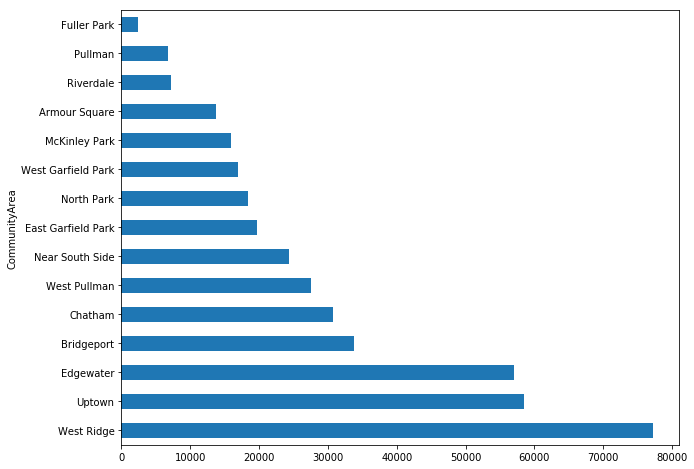

In [156]:
#Let's view a graph
df_candidates_ordered2 = df_candidates_ordered.set_index('CommunityArea')
ax_final = df_candidates_ordered2['Population'].plot.barh(rot=0, figsize=(10,8))